## Recover temporal latent causal factors with simulated data

### Initialize environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import ltcl
import numpy as np
from ltcl.modules.linear import AffineFlow
from ltcl.modules.components.tc import Discriminator, permute_dims
from ltcl.datasets.sim_dataset import SimulationDataset
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def freeze_flow(flow, module_name):
    module = getattr(flow, module_name)
    for param in module.parameters():
        param.requires_grad = False
        
def unfreeze_flow(flow, module_name):
    module = getattr(flow, module_name)
    for param in module.parameters():
        param.requires_grad = True

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
batch_size = 64
max_epochs = 5

In [5]:
train_dataset = SimulationDataset("train")
training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SimulationDataset("val")
validation_generator = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False)

In [6]:
flow = AffineFlow(input_size = 4, 
                  lags = 2,
                  batch_norm = True,
                  diagonal=False)
flow = flow.to(device)
d = Discriminator(80 * 4).to(device)

In [7]:
# Manual tuning
freeze_flow(flow, "dconv")
freeze_flow(flow, "unmix")
unfreeze_flow(flow, "spline")

In [8]:
spline_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, flow.parameters()), 
                                    lr=1e-3,
                                    weight_decay=0.0)

In [9]:
# Warm-start the prior to standard normal dist
for step in range(5000):
    latent_size = 4
#     y_1 = torch.exp(torch.normal(0, 1, size=(batch_size, latent_size//2)))
    y_1 = torch.normal(0, 1, size=(batch_size, latent_size//2))
                # y_2 = torch.rand(batch_size, latent_size//2) - 0.5
#     y_2 = torch.distributions.laplace.Laplace(0,1).rsample((batch_size, latent_size//2))
    y_2 = torch.normal(0, 1, size=(batch_size, latent_size//2))
    dataset = torch.cat((y_1, y_2), dim=1).to(device)
    spline_optimizer.zero_grad()
    z, logabsdet = flow.spline(dataset)
    logp = flow.base_dist.log_prob(z) + logabsdet
    loss = -torch.mean(logp)
    loss.backward(retain_graph=True)
    spline_optimizer.step()

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

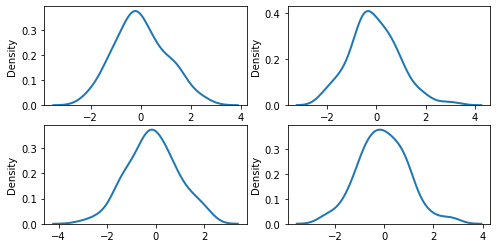

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(8,4))
for idx in range(4):
    row = idx // 2
    col = idx % 2
#     sns.distplot(y_t[:,idx], hist=False, kde=True,
#                  bins=None,
#                  hist_kws={'edgecolor':'black'},
#                  kde_kws={'linewidth': 2},
#                  ax = axs[row,col], label="prior");
#     axs[row,col].legend()
    sns.distplot(flow.sample_prior(128).detach().cpu().numpy()[:,idx], hist=False, kde=True,
                 bins=None,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2},
                 ax = axs[row,col], label="prior");

In [11]:
# Manual tuning
unfreeze_flow(flow, "dconv")
unfreeze_flow(flow, "unmix")
unfreeze_flow(flow, "spline")
flow_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, flow.parameters()), 
                                  lr=2e-4,
                                  weight_decay=0.0)
d_optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, d.parameters()), 
                               lr=1e-4)

In [12]:
# Manual tuning
# unfreeze_flow(flow, "dconv")
# unfreeze_flow(flow, "unmix")
# freeze_flow(flow, "spline")

In [13]:
def amari_distance(r):
    p = r.shape[0]
    abs_r = np.abs(r)
    l = np.sum(np.sum(abs_r, axis=1, keepdims=True) / np.max(abs_r, axis=1, keepdims=True) - 1, axis=0)
    r = np.sum(np.sum(abs_r, axis=0, keepdims=True) / np.max(abs_r, axis=0, keepdims=True) - 1, axis=1)
    return 1/(2*p*(p-1)) * (l+r)

In [14]:
BB2 = np.load("/home/cmu_wyao/projects/data/W2.npy")
BB1 = np.load("/home/cmu_wyao/projects/data/W1.npy")

### Training

In [15]:
batch_size = 64
ones = torch.ones(batch_size, dtype=torch.long, device=device)
zeros = torch.zeros(batch_size, dtype=torch.long, device=device)
eye = torch.eye(320, device=device)
gamma = 25
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    flow_running_loss = 0
    d_running_loss = 0
    for batch_sample1, batch_sample2 in training_generator:
        batch_x = batch_sample1["x"]
        batch_y = batch_sample1["y"]
        # Transfer to GPU
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        # Model computations
        flow_optimizer.zero_grad()
        log_prob, e = flow.log_prob(batch_x, batch_y)
        # Spatialtemporal decorrelation
#         posteriors = flow(batch_x, batch_y)[0].reshape(batch_size, -1)
#         fro_norm = torch.norm(torch.mm(posteriors.T, posteriors) - eye, "fro")
#         Total correlation
        e = e.reshape(batch_size, -1)
        D_e = d(e)
        tc_loss = (D_e[:, :1] - D_e[:, 1:]).mean()
        flow_loss = -log_prob + gamma * tc_loss #+ fro_norm #+ gamma * tc_loss
        flow_loss.backward(retain_graph=True)
        flow_optimizer.step()
        
        # Discrimator traing
        d_optimizer.zero_grad()
        e = e.detach()
        D_e = d(e)
        batch_xx = batch_sample2["x"]
        batch_yy = batch_sample2["y"]  
        # Transfer to GPU
        batch_xx, batch_yy = batch_xx.to(device), batch_yy.to(device)
        _, e_prime = flow.log_prob(batch_xx, batch_yy)
        e_prime = e_prime.reshape(batch_size, -1)
        e_perm = permute_dims(e_prime).detach()
        D_e_pperm = d(e_perm)
        if random.random() < 0.1:
            D_tc_loss = 0.5*(F.cross_entropy(D_e, ones) + F.cross_entropy(D_e_pperm, zeros))
        else:
            D_tc_loss = 0.5*(F.cross_entropy(D_e, zeros) + F.cross_entropy(D_e_pperm, ones))
        D_tc_loss.backward()
        d_optimizer.step()
        flow_running_loss += flow_loss.item()
        d_running_loss += D_tc_loss.item()

    print(f"Flow loss: {flow_running_loss/len(training_generator)} D loss: {d_running_loss/len(training_generator)}")
    # Validation
    running_loss = 0
    with torch.set_grad_enabled(False):
        for batch_sample, _ in validation_generator:
            # Transfer to GPU
            batch_x = batch_sample["x"]
            batch_y = batch_sample["y"]
            # Transfer to GPU
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            log_prob, _ = flow.log_prob(batch_x, batch_y)
            flow_loss = -log_prob
            running_loss += flow_loss.item()
        print(f"Validation loss: {running_loss/len(validation_generator)}")
    W2 = flow.dconv.step_func.wt_func.w[0].detach().cpu().numpy()
    W1 = flow.dconv.step_func.wt_func.w[1].detach().cpu().numpy()
    B2 = - W2
    B1 = - W1
    am2 = amari_distance(np.linalg.inv(B2) @ BB2)
    am1 = amari_distance(np.linalg.inv(B1) @ BB1)
    print(f"Amari index: {am2[0], am1[0]}")

Flow loss: -1100.39602268219 D loss: 0.6931544499099255
Validation loss: -1126.9831030273438
Amari index: (0.11378517, 0.21527347)
Flow loss: -1132.454105606079 D loss: 0.6931538905203343
Validation loss: -1135.4284301757812
Amari index: (0.07188438, 0.13274081)


KeyboardInterrupt: 

In [16]:
W2 = flow.dconv.step_func.wt_func.w[0].detach().cpu().numpy()
W1 = flow.dconv.step_func.wt_func.w[1].detach().cpu().numpy()
B2 = - W2
B1 = - W1
am2 = amari_distance(np.linalg.inv(B2) @ BB2)
am1 = amari_distance(np.linalg.inv(B1) @ BB1)
print(f"Amari index: {am2[0], am1[0]}")

Amari index: (0.07125473, 0.14149272)


In [17]:
samples = flow.sample(batch_y, batch_y.shape[0], 80)

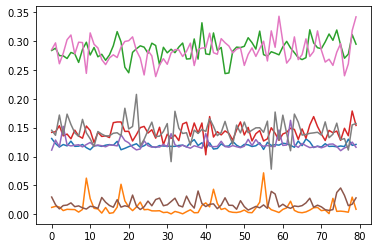

In [18]:
plt.plot(samples[3].detach().cpu().numpy())
plt.plot(batch_x[3].detach().cpu().numpy())

In [65]:
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    running_loss = 0
    for batch_sample1, _ in training_generator:
        batch_x = batch_sample1["x"]
        batch_y = batch_sample1["y"]
        # Transfer to GPU
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        # Model computations
        log_prob, e = flow.log_prob(batch_x, batch_y)
        flow_loss = -log_prob
        flow_optimizer.zero_grad()
        flow_loss.backward(retain_graph=True)
        flow_optimizer.step()
        running_loss += flow_loss.item()

    print(f"Training loss: {running_loss/len(training_generator)}")
    # Validation
    running_loss = 0
    with torch.set_grad_enabled(False):
        for batch_sample, _ in validation_generator:
            # Transfer to GPU
            batch_x = batch_sample["x"]
            batch_y = batch_sample["y"]
            # Transfer to GPU
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            log_prob, _ = flow.log_prob(batch_x, batch_y)
            flow_loss = -log_prob
            running_loss += flow_loss.item()
        print(f"Validation loss: {running_loss/len(validation_generator)}")
    W2 = flow.dconv.step_func.wt_func.w[0].detach().cpu().numpy()
    W1 = flow.dconv.step_func.wt_func.w[1].detach().cpu().numpy()
    B2 = - W2
    B1 = - W1
    am2 = amari_distance(np.linalg.inv(B2) @ BB2)
    am1 = amari_distance(np.linalg.inv(B1) @ BB1)
    print(f"Amari index: {am2[0], am1[0]}")

Training loss: -1132.3906716156007
Validation loss: -1134.5599560546875
Amari index: (0.11576824, 0.29935262)
Training loss: -1135.4574696350098
Validation loss: -1136.5617919921874
Amari index: (0.104606986, 0.28308854)
Training loss: -1136.879738922119
Validation loss: -1137.6513427734376
Amari index: (0.09617704, 0.27001315)
Training loss: -1137.9831442260743
Validation loss: -1138.812470703125
Amari index: (0.09751852, 0.27203345)
Training loss: -1138.8533347320556
Validation loss: -1139.6533349609374
Amari index: (0.10028392, 0.2727099)


/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

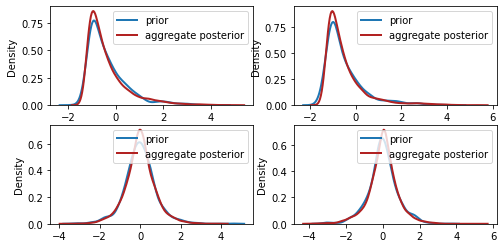

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(8,4))
for idx in range(4):
    row = idx // 2
    col = idx % 2
    sns.distplot(flow.sample_prior(1000).detach().cpu().numpy()[:,idx], hist=False, kde=True,
                 bins=None,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2},
                 ax = axs[row,col], label="prior");
    sns.distplot(flow(batch_x, batch_y)[0][:,:,idx].reshape(-1).detach().cpu().numpy(), hist=False, kde=True,
                 bins=None, color='firebrick',
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2},
                 label='aggregate posterior',
                 ax = axs[row, col]);
    axs[row,col].legend()

In [20]:
# # Loop over epochs
# for epoch in range(max_epochs):
#     # Training
#     running_loss = 0
#     for batch_sample1, _ in training_generator:
#         batch_x = batch_sample1["x"]
#         batch_y = batch_sample1["y"]
#         # Transfer to GPU
#         batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#         # Model computations
#         log_prob, e = flow.log_prob(batch_x, batch_y)
#         # Spatialtemporal decorrelation
# #         posteriors = flow(batch_x, batch_y)[0].reshape(batch_size, -1)
# #         fro_norm = torch.norm(torch.mm(posteriors.T, posteriors) - eye, "fro")
# #         Total correlation
# #         e = e.reshape(batch_size, -1)
# #         D_e = d(e)
# #         tc_loss = (D_e[:, :1] - D_e[:, 1:]).mean()
#         flow_loss = -log_prob #+ gamma * tc_loss #+ fro_norm #+ gamma * tc_loss
#         flow_optimizer.zero_grad()
#         flow_loss.backward(retain_graph=True)
#         flow_optimizer.step()
        
#         # Discrimator traing
# #         e = e.detach()
# #         D_e = d(e)
# #         batch_xx = batch_sample2["x"]
# #         batch_yy = batch_sample2["y"]  
# #         # Transfer to GPU
# #         batch_xx, batch_yy = batch_xx.to(device), batch_yy.to(device)
# #         _, e_prime = flow.log_prob(batch_xx, batch_yy)
# #         e_prime = e_prime.reshape(batch_size, -1)
# #         e_perm = permute_dims(e_prime).detach()
# #         D_e_pperm = d(e_perm)
# #         D_tc_loss = 0.5*(F.cross_entropy(D_e, zeros) + F.cross_entropy(D_e_pperm, ones))
# #         d_optimizer.zero_grad()
# #         D_tc_loss.backward()
# #         d_optimizer.step()
#         running_loss += flow_loss.item()

#     print(f"Training loss: {running_loss/len(training_generator)}")
#     # Validation
#     running_loss = 0
#     with torch.set_grad_enabled(False):
#         for batch_sample, _ in validation_generator:
#             # Transfer to GPU
#             batch_x = batch_sample["x"]
#             batch_y = batch_sample["y"]
#             # Transfer to GPU
#             batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#             log_prob, _ = flow.log_prob(batch_x, batch_y)
#             flow_loss = -log_prob
#             running_loss += flow_loss.item()
#         print(f"Validation loss: {running_loss/len(validation_generator)}")
#     W2 = flow.dconv.step_func.wt_func.w[0].detach().cpu().numpy()
#     W1 = flow.dconv.step_func.wt_func.w[1].detach().cpu().numpy()
#     B2 = - W2
#     B1 = - W1
#     am2 = amari_distance(np.linalg.inv(B2) @ BB2)
#     am1 = amari_distance(np.linalg.inv(B1) @ BB1)
#     print(f"Amari index: {am2[0], am1[0]}")

In [21]:
def align_matrices(B1, B2, BB1, BB2):
    b = np.concatenate((B1,B2), axis=0)
    bb = np.concatenate((BB1,BB2), axis=0)
    C = np.zeros((4,4))
    for i in range(4):
        C[i] = -np.abs(np.corrcoef(np.concatenate((b[:,i:i+1], bb),axis=1), rowvar=False)[0,1:])
    row_ind, col_ind = linear_sum_assignment(C)
    bb = bb[:, col_ind]
    for col in range(4):
        if np.corrcoef(np.concatenate((b[:,col:col+1], bb),axis=1), rowvar=False)[0,1:][col] < 0:
            bb[:, col] = -bb[:, col]
    b = b / np.linalg.norm(b, axis=0)
    bb = bb / np.linalg.norm(bb, axis=0)
    am1 = amari_distance(np.linalg.inv(bb[4:]) @ bb[4:])

In [22]:
b = np.concatenate((B1,B2), axis=0)
bb = np.concatenate((BB1,BB2), axis=0)
C = np.zeros((4,4))
for i in range(4):
    C[i] = -np.abs(np.corrcoef(np.concatenate((b[:,i:i+1], bb),axis=1), rowvar=False)[0,1:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
bb = bb[:, col_ind]
for col in range(4):
    if np.corrcoef(np.concatenate((b[:,col:col+1], bb),axis=1), rowvar=False)[0,1:][col] < 0:
        bb[:, col] = -bb[:, col]
b = b / np.linalg.norm(b, axis=0).reshape(1, -1)
bb = bb / np.linalg.norm(bb, axis=0).reshape(1, -1)
pred = (b / np.linalg.norm(b, axis=0).reshape(1, -1)).reshape(-1)
true = (bb / np.linalg.norm(bb, axis=0).reshape(1, -1)).reshape(-1)

Text(0, 0.5, 'Ground truth weight')

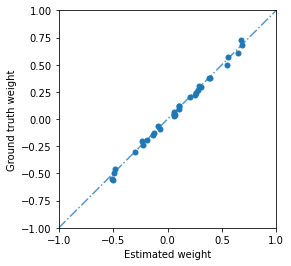

In [23]:
fig, ax = plt.subplots()
ax.scatter(pred, true, s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [-1,1
]

# now plot both limits against eachother
ax.plot(lims, lims, '-.', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Estimated weight")
ax.set_ylabel("Ground truth weight")

In [24]:
from sklearn.metrics import r2_score

In [25]:
r2_score(pred,true)

0.9951177511133503